In [15]:
using Knet
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take, repeat
using Plots; default(fmt=:png,ls=:auto)

STANFORD GLOVE EMBEDDINGS 

In [16]:
f = open("glove.42B.300d.txt")

IOStream(<file glove.42B.300d.txt>)

In [17]:
lines = readlines(f);

In [18]:
embeddingdict = Dict()
embeddingindex = 1
for line in lines
    strword = split(line)
    strname = strword[1]
    embeddingdict[strname] = embeddingindex
    embeddingindex+=1
end

SENTIMENT TREEBANK DATA

In [105]:
txt1 = open("sentences.txt")
lines1 = readlines(txt1)
txt2 = open("labels.txt")
lines2 = readlines(txt2);

In [106]:
all_sentences = (x -> split(x)).(lines1);
all_sentences = [(x -> lowercase(x)).(s) for s in all_sentences]
        
train_sentences2 = all_sentences[1:8534]
test_sentences2 = all_sentences[8535:10744]
val_sentences2 = all_sentences[10745:11844]

train_labels = lines2[1:8534]
train_labels = (x -> parse(Float32, x)).(train_labels)
test_labels = lines2[8535:10744]
val_labels = lines2[10745:11844];

In [107]:
function mapfloat(label)
    if (0 <= label < 0.2); return 1; end;
    #if (0.4 <= label < 0.6); return 2; end;
    #if (0.6 <= label <= 1.0); return 3; end;
    if (0.2 <= label < 0.4); return 2; end;
    if (0.4 <= label < 0.6); return 3; end;
    if (0.6 <= label < 0.8); return 4; end;
    if (0.8 <= label <= 1.0); return 5; end;
end
train_labels = (x->mapfloat(x)).(train_labels);

In [108]:
function mapx(label)
    if label == "very neg" return 1; end;
    if label == "neg" return 2; end;
    if label == "neu" return 3; end;
    if label == "pos" return 4; end;
    if label == "very pos" return 5; end;
end
test_labels = (x->mapx(x)).(test_labels);

In [5]:
vocab = []
for sentence in all_sentences
    for word in sentence
        if !(word in vocab); push!(vocab, word);end
    end
end

In [6]:
push!(vocab, "UNK");

In [109]:
w2i = Dict()
i2w = Dict()
dictindex = 1
for word in vocab
    w2i[word] = dictindex
    i2w[dictindex] = word
    dictindex+=1
end
w2i["UNK"] = 19507
i2w[19507] = "UNK";

In [110]:
all_sentences = [(x -> w2i[x]).(s) for s in all_sentences];

In [111]:
train_sentences = all_sentences[1:8534]
test_sentences = all_sentences[8535:10744]
val_sentences = all_sentences[10745:11844];

In [112]:
maxlength = 52
for sentence in train_sentences
    while length(sentence) != maxlength
        pushfirst!(sentence,w2i["UNK"])
    end
end

In [113]:
maxlength = 56
for sentence in test_sentences
    while length(sentence) != maxlength
        pushfirst!(sentence,w2i["UNK"])
    end
end

CONSTRUCTING THE EMBEDDING MATRIX

In [114]:
embedmatrix = []
no_embeddings = []
count = 0
for word in vocab
    if word in keys(embeddingdict)
        wordvector = (x-> parse(Float32, x)).(split(lines[embeddingdict[word]])[2:301])
        count += 1
    else
        wordvector = xavier(Float32, 300)
        push!(no_embeddings, (word, wordvector))
    end
    push!(embedmatrix, hcat(wordvector))
end

In [115]:
embedmatrix = hcat(embedmatrix...);

In [116]:
size(embedmatrix)

(300, 19507)

In [117]:
println(count, " out of ", length(vocab), " words are in Stanford Glove Embeddings. The rest is initialized randomly.")

18593 out of 19507 words are in Stanford Glove Embeddings. The rest is initialized randomly.


In [118]:
#CHECK that it works
checker = []
for line in lines
    sentence = split(line)
    if sentence[1] == "terrible"
        checker = (sentence[2:301])
        break;
    end
end

(x -> parse(Float32, x)).(checker) == embedmatrix[:,w2i["terrible"]]

true

SET UP MODEL

In [119]:
# Set constants for the model and training
EPOCHS=3                  # Number of training epochs
BATCHSIZE=5               # Number of instances in a minibatch
EMBEDSIZE=300             # Word embedding size
NUMHIDDEN=100             # Hidden layer size
MAXLEN=150                # maximum size of the word sequence, pad shorter sequences, truncate longer ones
VOCABSIZE=length(vocab)   # maximum vocabulary size, keep the most frequent 30K, map the rest to UNK token
NUMCLASS=5                # number of output classes
DROPOUT=0.5               # Dropout rate
LR=0.002                  # Learning rate
BETA_1=0.9                # Adam optimization parameter
BETA_2=0.999              # Adam optimization parameter
EPS=1e-08                 # Adam optimization parameter

1.0e-8

In [180]:
struct LSTMN; input; rnn; output; pdrop; end

In [181]:
LSTMN(input::Int, embed::Int, hidden::Int, output::Int; pdrop=0) =
    LSTMN(param(KnetArray(embedmatrix)), RNN(embed,hidden,rnnType=:gru), param(output,hidden), pdrop)

LSTMN

In [182]:
LSTMN(input,rnn,output;pdrop=0) = LSTMN(input,rnn,output,pdrop)

LSTMN

In [183]:
function (lstmn::LSTMN)(input)
    embed = lstmn.input[:, permutedims(hcat(input...))]
    embed = dropout(embed,lstmn.pdrop)
    hidden = lstmn.rnn(embed)
    hidden = dropout(hidden,lstmn.pdrop)
    return lstmn.output * hidden[:,:,end]
end

In [184]:
(lstmn::LSTMN)(input,output) = nll(lstmn(input),output)
(lstmn::LSTMN)(d::Knet.Data) = Knet.mean(lstmn(x,y) for (x,y) in d)

In [250]:
dtrn = minibatch(train_sentences,train_labels,BATCHSIZE;shuffle=true)
dtst = minibatch(test_sentences,test_labels ,BATCHSIZE)
length(dtrn), length(dtst)

(1706, 442)

In [212]:
model = LSTMN(VOCABSIZE,EMBEDSIZE,NUMHIDDEN,NUMCLASS,pdrop=DROPOUT)

LSTMN(P(KnetArray{Float32,2}(300,19507)), GRU(input=300,hidden=100), P(KnetArray{Float32,2}(5,100)), 0.5)

In [187]:
x1, y1 = first(dtst);
embed = model.input[:, permutedims(hcat(x1...))]
embed = dropout(embed, model.pdrop)
hidden = model.rnn(embed)
hidden = dropout(hidden, model.pdrop)
model.output * hidden[:,:,end]

5×5 KnetArray{Float32,2}:
 0.101645   -0.0446521  0.0929932  0.0911249   0.172984 
 0.15083     0.161641   0.139841   0.286315    0.287642 
 0.0274723   0.0988777  0.11623    0.116379    0.0364922
 0.0566735   0.079221   0.0980748  0.0276994  -0.0672155
 0.054675    0.0770512  0.141116   0.112153    0.0599463

In [213]:
accuracy(model, dtrn), accuracy(model, dtst)

(0.2107854630715123, 0.18959276018099547)

In [211]:
models = []
results = []

0-element Array{Any,1}

In [190]:
function mytrain!(lstmn::LSTMN, dtrn, dtst,valid=10, max_iters=500)
        
    function pusher(lstmn::LSTMN,dtrn,dtst,trnloss,tstloss)
        push!(trnloss, lstmn(dtrn))
        push!(tstloss, lstmn(dtst))
    end
        
    trnloss = []
    tstloss = []
    
    takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)            
    #progress!(adam(model,repeat(dtrn,EPOCHS);lr=LR,beta1=BETA_1,beta2=BETA_2,eps=EPS))

    #change the optimizer here: sgd, adam, ... @doc Knet.sgd to see other options :
    #a = sgd(sc, take(cycle(dtrn), max_iters+1))    
                
    a = adam(lstmn, take(cycle(dtrn), max_iters+1);lr=LR,beta1=BETA_1,beta2=BETA_2,eps=EPS)        

    b = (pusher(lstmn,dtrn,dtst,trnloss,tstloss) for x in takeevery(valid, a))
    progress!(b)    
    return 0:valid:max_iters, trnloss, tstloss
end

mytrain! (generic function with 6 methods)

In [203]:
function tgraph(lstmn::LSTMN, dtrn, dtst, valid=10, max_iters=500)
    Training_Accuracy = accuracy(lstmn, dtrn)
    Test_Accuracy = accuracy(lstmn, dtst)
    println("Training Accuracy: ", accuracy(lstmn, dtrn))
    println("Test Accuracy: ", accuracy(lstmn, dtst))
    
    iters, trnloss, tstloss = mytrain!(lstmn,dtrn,dtst,valid,max_iters)
    
    println("Training Accuracy: ", accuracy(lstmn, dtrn))
    println("Test Accuracy: ", accuracy(lstmn, dtst))
    
    push!(models, model)
    push!(results, [accuracy(lstmn, dtrn), accuracy(lstmn, dtst), memo, (iters,trnloss,tstloss)])

    plot(iters, [trnloss, tstloss], labels=[:trn, :tst], xlabel="iterations", ylabel="loss")
end

tgraph (generic function with 6 methods)

Training Accuracy: 0.2107854630715123
Test Accuracy: 0.18959276018099547
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3154747948417351
Test Accuracy: 0.3004524886877828


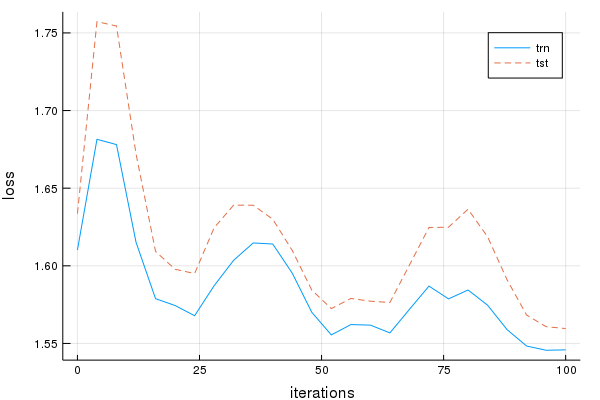

In [214]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3154747948417351
Test Accuracy: 0.3004524886877828
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3536928487690504
Test Accuracy: 0.33619909502262446


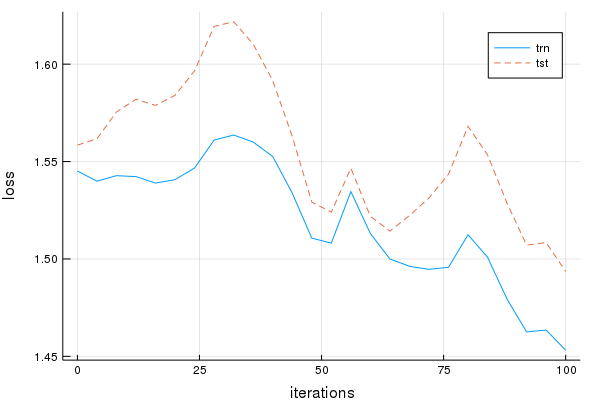

In [215]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3536928487690504
Test Accuracy: 0.33619909502262446
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3417350527549824
Test Accuracy: 0.3018099547511312


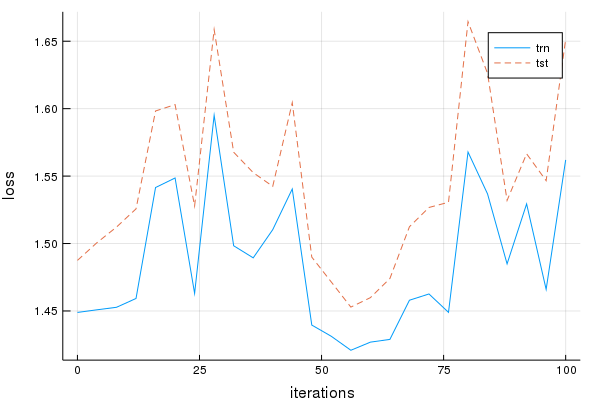

In [216]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3417350527549824
Test Accuracy: 0.3018099547511312
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3627198124267292
Test Accuracy: 0.334841628959276


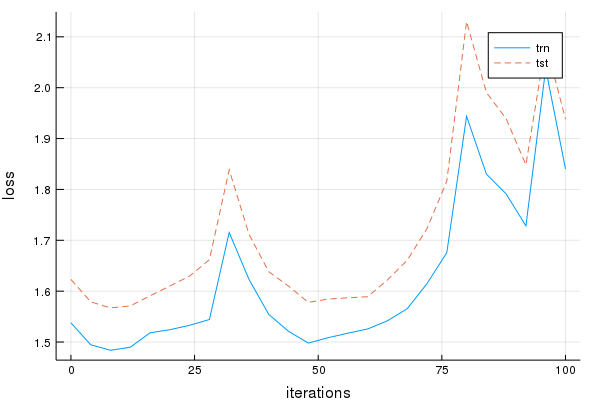

In [217]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3627198124267292
Test Accuracy: 0.334841628959276
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.38042203985932005
Test Accuracy: 0.34524886877828054


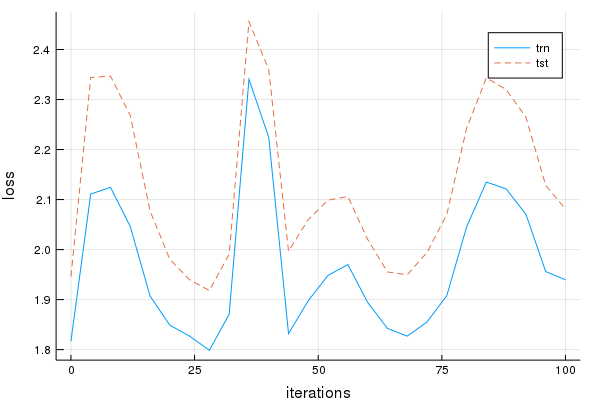

In [218]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.38042203985932005
Test Accuracy: 0.34524886877828054
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3468933177022274
Test Accuracy: 0.31447963800904977


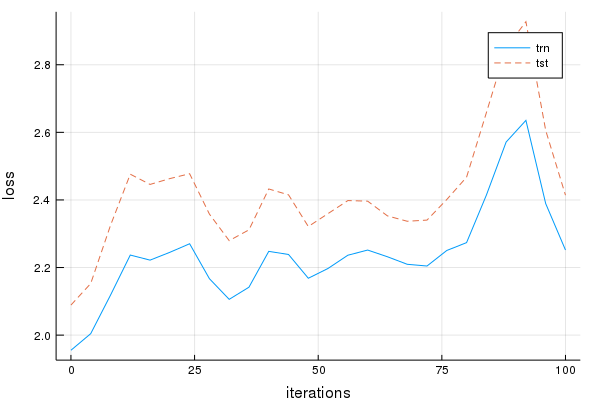

In [219]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3468933177022274
Test Accuracy: 0.31447963800904977
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3514654161781946
Test Accuracy: 0.3054298642533937


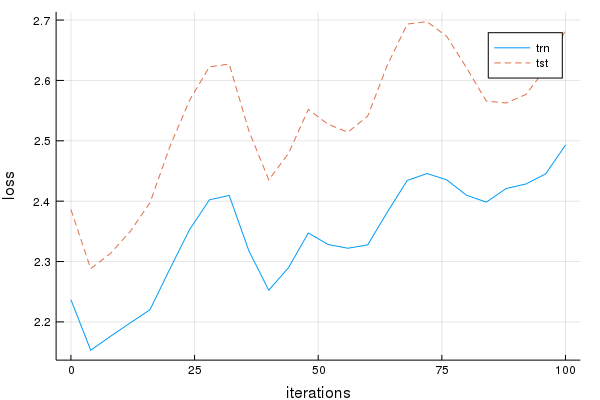

In [220]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3514654161781946
Test Accuracy: 0.3054298642533937
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.36178194607268466
Test Accuracy: 0.3072398190045249


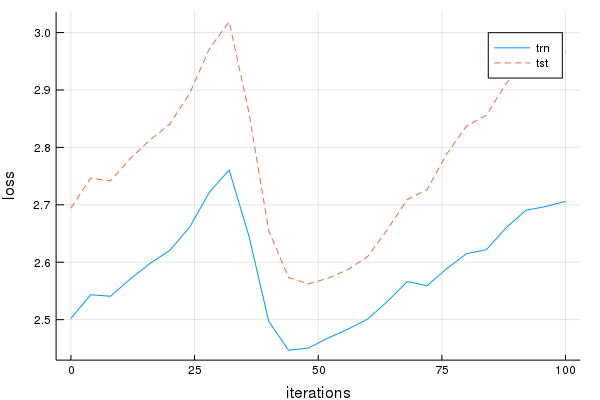

In [221]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.36178194607268466
Test Accuracy: 0.3072398190045249
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3607268464243845
Test Accuracy: 0.3058823529411765


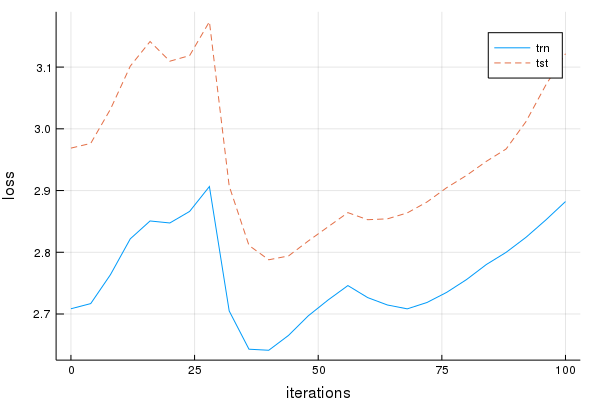

In [222]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3607268464243845
Test Accuracy: 0.3058823529411765
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.37878077373974206
Test Accuracy: 0.3416289592760181


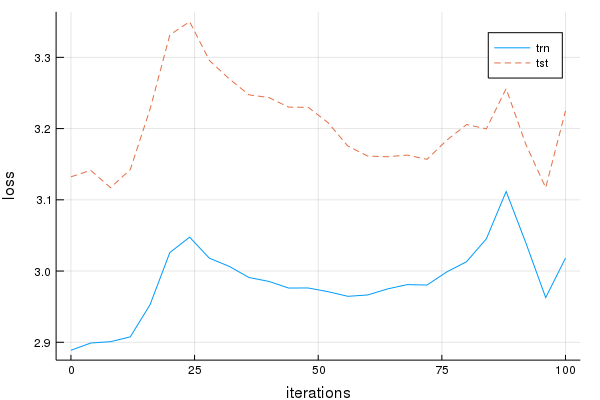

In [223]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.37878077373974206
Test Accuracy: 0.3416289592760181
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.34443141852286047
Test Accuracy: 0.29366515837104074


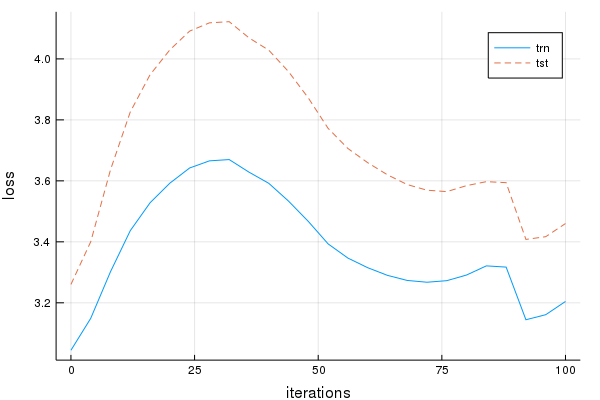

In [224]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.34443141852286047
Test Accuracy: 0.29366515837104074
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3652989449003517
Test Accuracy: 0.31085972850678734


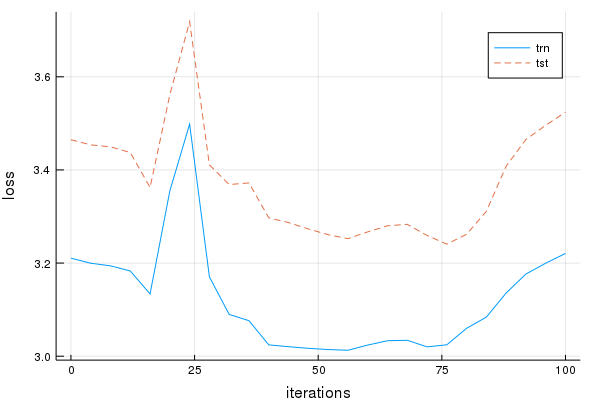

In [225]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3652989449003517
Test Accuracy: 0.31085972850678734
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3702227432590856
Test Accuracy: 0.332579185520362


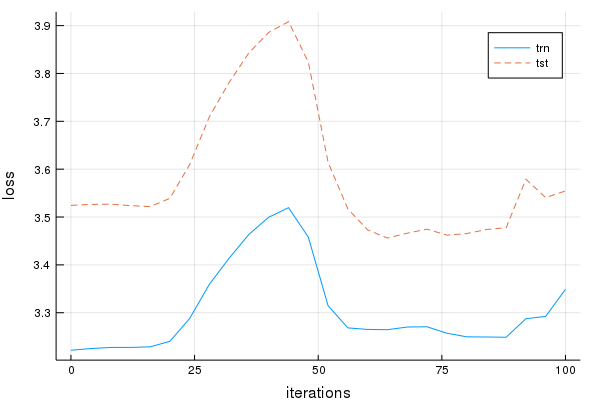

In [226]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3702227432590856
Test Accuracy: 0.332579185520362
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.68s/i]
Training Accuracy: 0.37467760844079717
Test Accuracy: 0.33031674208144796


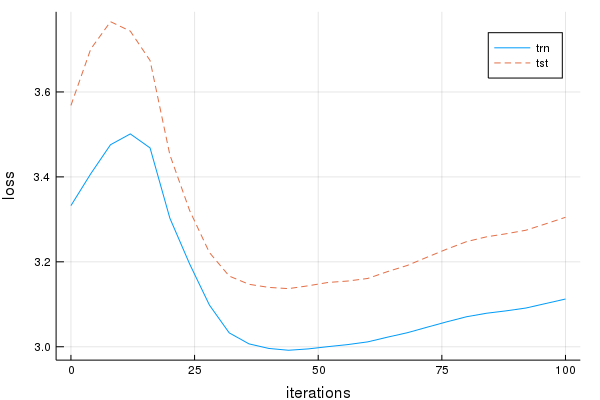

In [227]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.37467760844079717
Test Accuracy: 0.33031674208144796
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.37561547479484175
Test Accuracy: 0.334841628959276


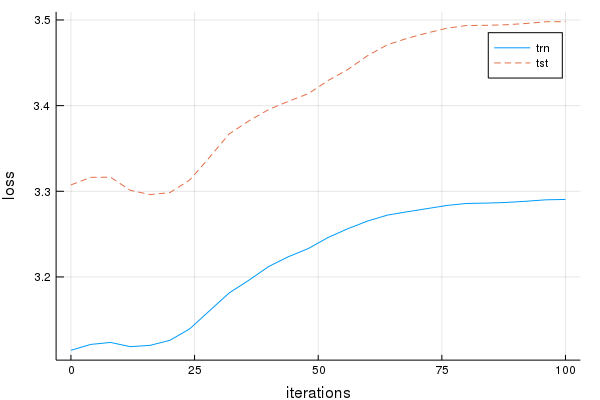

In [228]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.37561547479484175
Test Accuracy: 0.334841628959276
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.36799531066822977
Test Accuracy: 0.33031674208144796


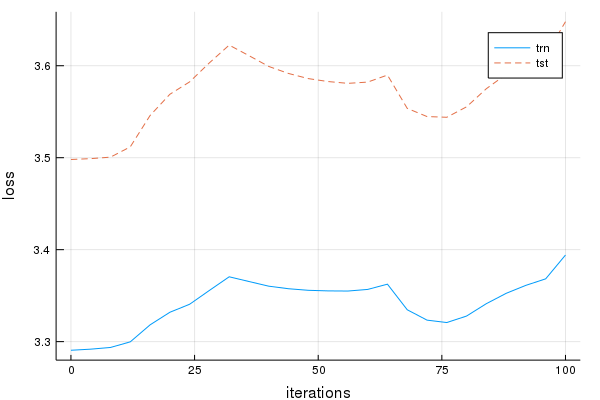

In [229]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.36799531066822977
Test Accuracy: 0.33031674208144796
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.37971864009378664
Test Accuracy: 0.3389140271493213


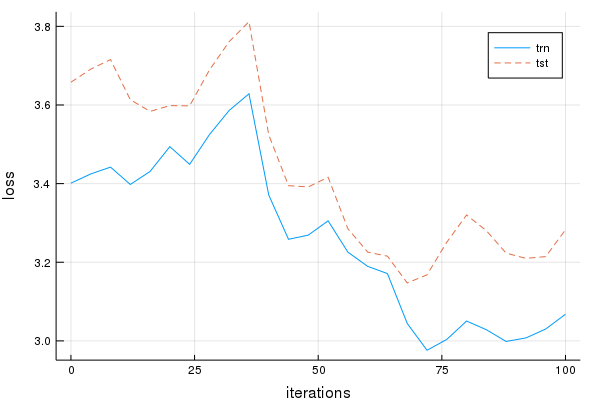

In [230]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.37971864009378664
Test Accuracy: 0.3389140271493213
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3526377491207503
Test Accuracy: 0.318552036199095


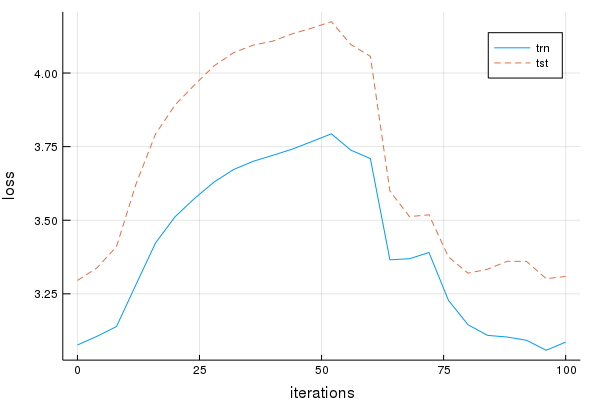

In [231]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3526377491207503
Test Accuracy: 0.318552036199095
┣   /       /       /       /       /       /       /       ┫ 26 [02:02, 4.69s/i]
Training Accuracy: 0.3595545134818288
Test Accuracy: 0.3081447963800905


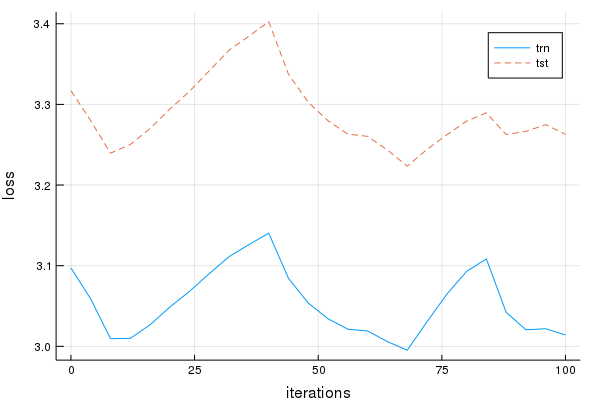

In [232]:
tgraph(model, dtrn, dtst, 4, 100)

Training Accuracy: 0.3595545134818288
Test Accuracy: 0.3081447963800905
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.469284876905041
Test Accuracy: 0.4294117647058823


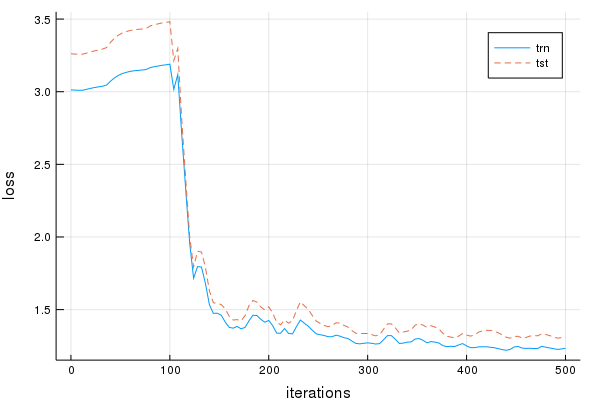

In [233]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.469284876905041
Test Accuracy: 0.4294117647058823
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5427901524032825
Test Accuracy: 0.432579185520362


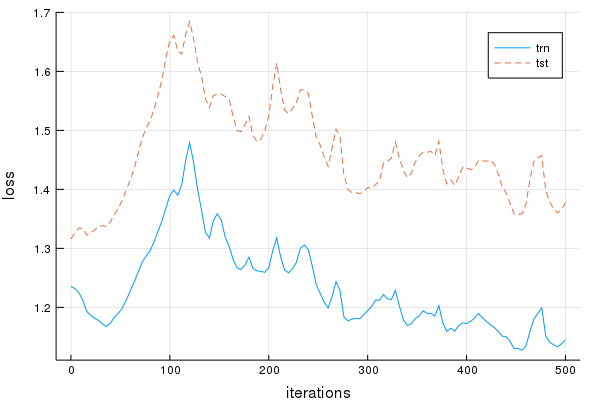

In [234]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5427901524032825
Test Accuracy: 0.432579185520362
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5681125439624853
Test Accuracy: 0.41312217194570133


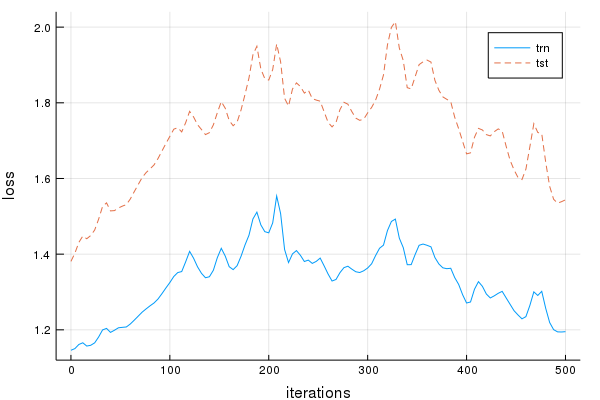

In [235]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5681125439624853
Test Accuracy: 0.41312217194570133
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5699882766705744
Test Accuracy: 0.3986425339366516


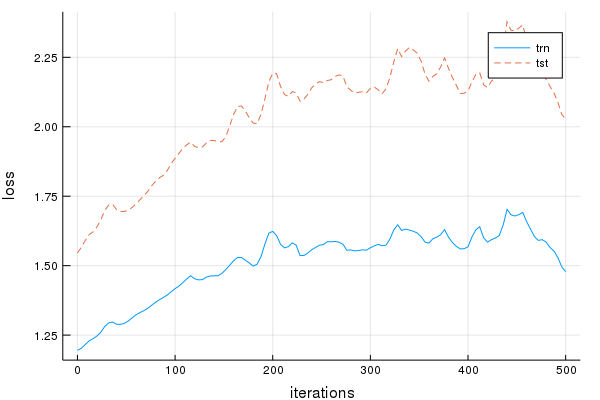

In [236]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5699882766705744
Test Accuracy: 0.3986425339366516
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5579132473622509
Test Accuracy: 0.3895927601809955


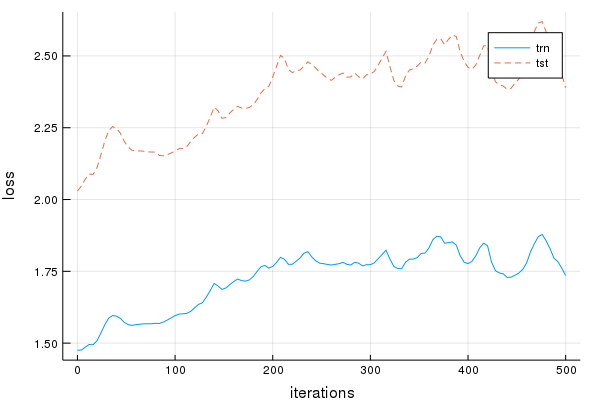

In [237]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5579132473622509
Test Accuracy: 0.3895927601809955
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5611957796014068
Test Accuracy: 0.3904977375565611


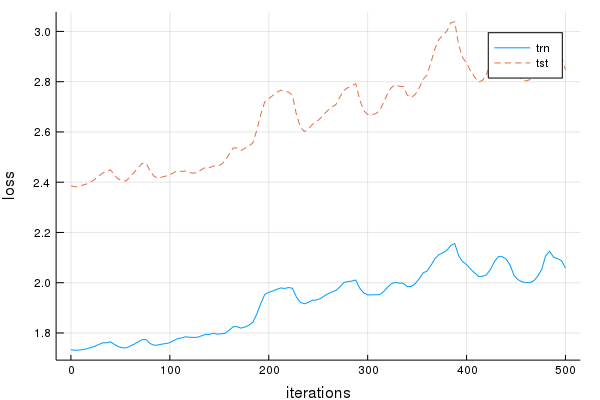

In [238]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5611957796014068
Test Accuracy: 0.3904977375565611
┣       /       /       /       /       /       /       /  ┫ 126 [09:50, 4.68s/i]
Training Accuracy: 0.5556858147713951
Test Accuracy: 0.38190045248868776


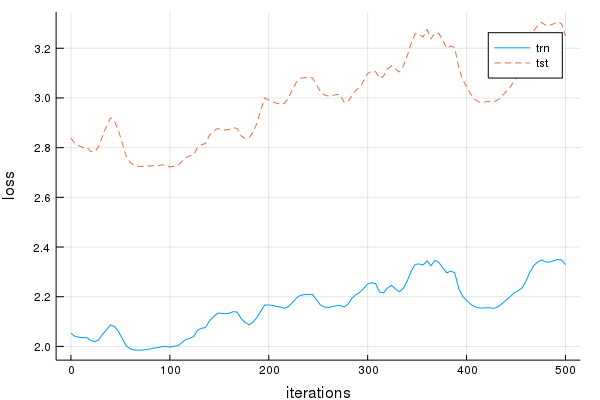

In [239]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5556858147713951
Test Accuracy: 0.38190045248868776
┣       /       /       /       /       /       /       /  ┫ 126 [09:51, 4.69s/i]
Training Accuracy: 0.5569753810082063
Test Accuracy: 0.3904977375565611


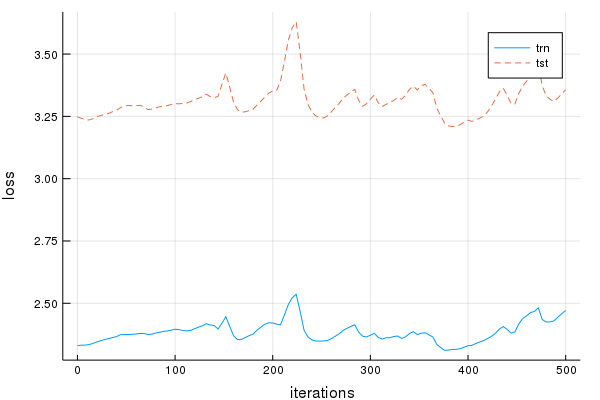

In [240]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5569753810082063
Test Accuracy: 0.3904977375565611
┣       /       /       /       /       /       /       /  ┫ 126 [09:52, 4.70s/i]
Training Accuracy: 0.5531066822977726
Test Accuracy: 0.3746606334841629


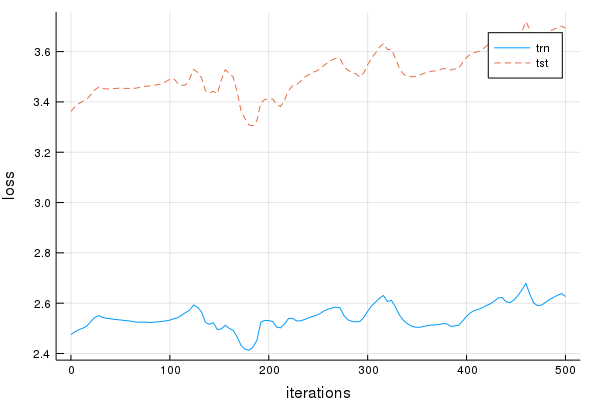

In [241]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5531066822977726
Test Accuracy: 0.3746606334841629
┣       /       /       /       /       /       /       /  ┫ 126 [09:53, 4.71s/i]
Training Accuracy: 0.5568581477139508
Test Accuracy: 0.38371040723981903


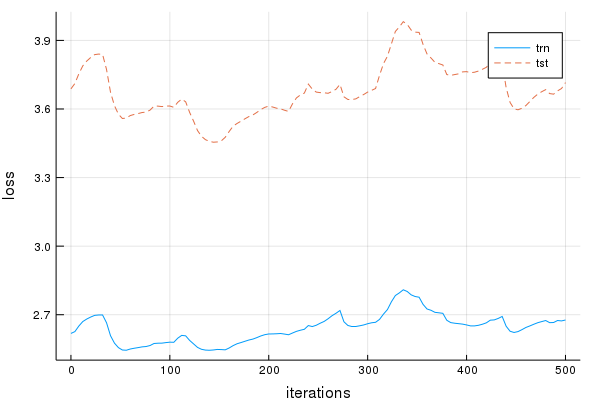

In [242]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5568581477139508
Test Accuracy: 0.38371040723981903
┣       /       /       /       /       /       /       /  ┫ 126 [09:54, 4.72s/i]
Training Accuracy: 0.5546307151230949
Test Accuracy: 0.3760180995475113


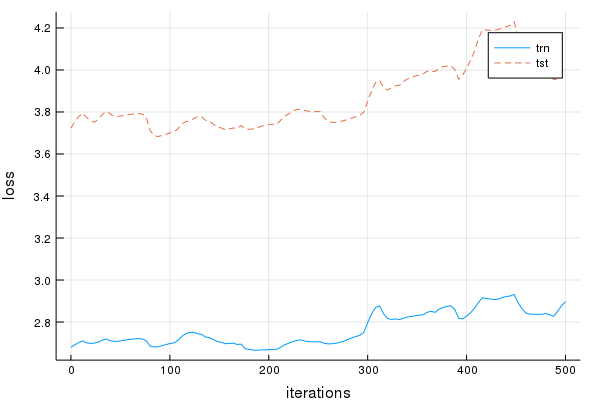

In [243]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5546307151230949
Test Accuracy: 0.3760180995475113
┣       /       /       /       /       /       /       /  ┫ 126 [09:55, 4.72s/i]
Training Accuracy: 0.5580304806565064
Test Accuracy: 0.37873303167420813


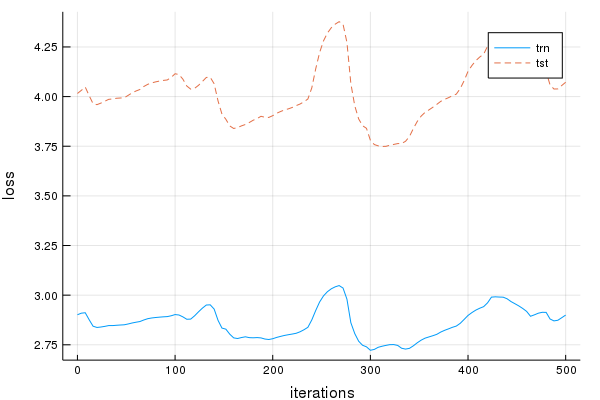

In [244]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5580304806565064
Test Accuracy: 0.37873303167420813
┣       /       /       /       /       /       /       /  ┫ 126 [09:55, 4.72s/i]
Training Accuracy: 0.5450175849941383
Test Accuracy: 0.3669683257918552


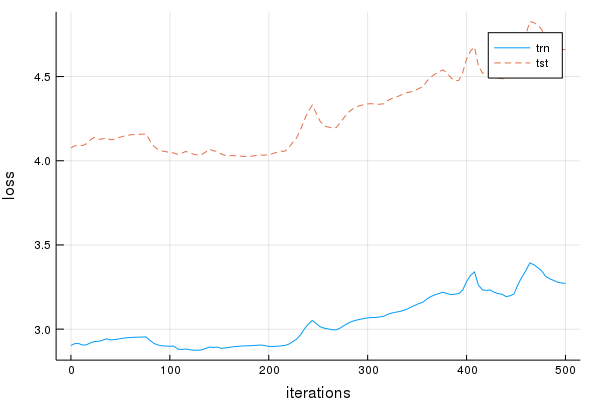

In [245]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5450175849941383
Test Accuracy: 0.3669683257918552
┣       /       /       /       /       /       /       /  ┫ 126 [09:52, 4.70s/i]
Training Accuracy: 0.5412661195779601
Test Accuracy: 0.36199095022624433


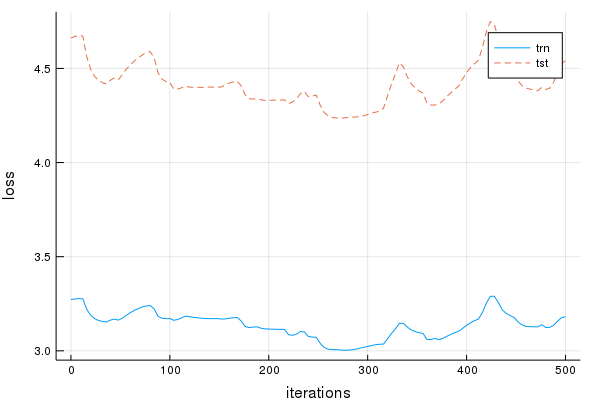

In [246]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.541852286049238
Test Accuracy: 0.34479638009049773
┣       /       /       /       /       /       /       /  ┫ 126 [09:53, 4.70s/i]
Training Accuracy: 0.5937866354044549
Test Accuracy: 0.3891402714932127


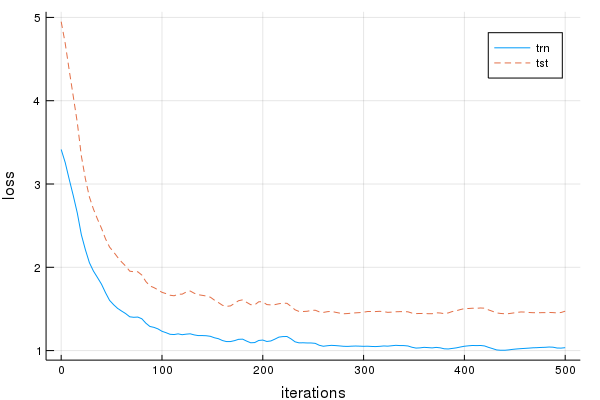

In [251]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.5937866354044549
Test Accuracy: 0.3891402714932127
┣       /       /       /       /       /       /       /  ┫ 126 [09:54, 4.71s/i]
Training Accuracy: 0.6611957796014069
Test Accuracy: 0.4149321266968326


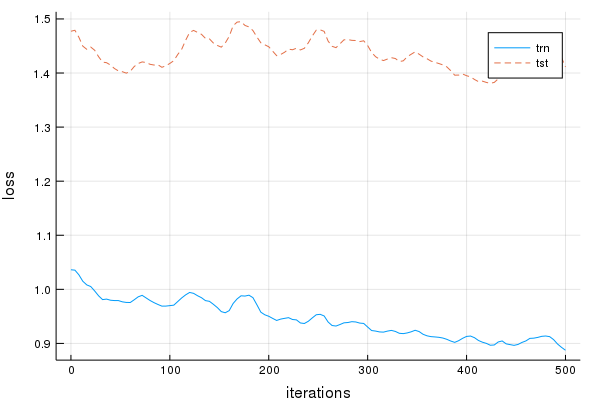

In [252]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.6609613130128956
Test Accuracy: 0.4149321266968326
┣       /       /       /       /       /       /       /  ┫ 126 [09:53, 4.70s/i]
Training Accuracy: 0.6948417350527549
Test Accuracy: 0.42081447963800905


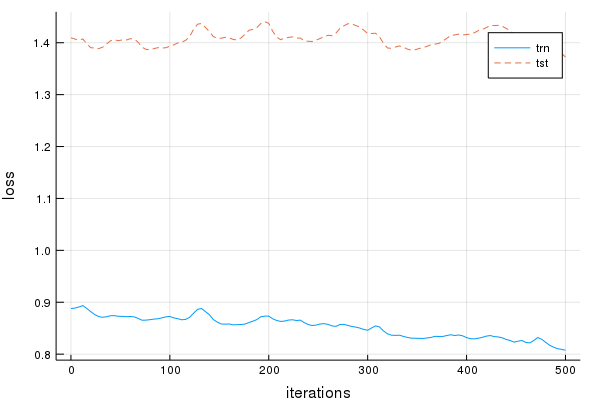

In [253]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.6961313012895662
Test Accuracy: 0.41312217194570133
┣       /       /       /       /       /       /       /  ┫ 126 [09:55, 4.72s/i]
Training Accuracy: 0.725556858147714
Test Accuracy: 0.4312217194570136


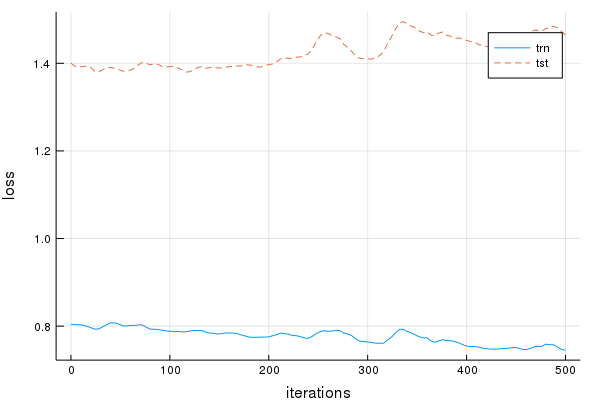

In [265]:
tgraph(model, dtrn, dtst, 4, 500)

In [ ]:
tgraph(model, dtrn, dtst, 4, 500)

Training Accuracy: 0.7252051582649472
Test Accuracy: 0.4312217194570136


In [ ]:
tgraph(model, dtrn, dtst, 4, 500)